# Dark Side of the Volume

Welcome to the <i> Dark Side of the Volume Challenge</i>! Your job for this challenge, is to build a model that ingests 3D seismic volumes and identifies subsurface faults within them. This challenge is not just about coding; it’s about diving deep into the Earth’s crust and uncovering the hidden secrets beneath. For more details about the rules and requirements, please visit the [challenge page](https://thinkonward.com/app/c/challenges).

Did you know that rocks can bend and break just like a piece of lumber? Due to the immense pressure in the Earth’s crust, rocks are constantly stressed and deformed. Over time, this pressure can cause rocks to bend and squash like taffy on a hot summer day. However, if the stress is intense enough over a short period, the rocks will break and form faults. These faults are the battlegrounds where the Earth’s internal forces clash, leading to the earthquakes we experience today. Your task is to find these faults and contribute to our understanding of the in the subsurface. So, gear up, and let’s rock this challenge!

### Supplied Materials:

* Starter Notebook.
* Training data: 400 samples, each containing a synthetic 3D seismic volume and a corresponding fault volume.
* Test data: 50 samples,  each containing a synthetic 3D seismic volume (with no fault data; this is what you are going to predict!).
* `utils.py` script containing helpful functions.
* `requirements.txt` should contain all required packages.

### Imports

In [1]:
# ONLY RUN THIS CELL ONCE
#!pip install xarray

In [2]:
import os
import time
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import scipy
from typing import Union, Tuple

from utils import *

### Data:

You can download the train and test data from the challenge’s webpage or portal under the data tab.

Assuming you have downloaded and organized all the training data into a folder named `training_data`, this folder will contain 400 subfolders. Each subfolder represents a training sample, and the name of each subfolder corresponds to the Sample ID for that sample. Below we list 5 of these sample IDs.


In [3]:
# Directory path
training_data = os.path.join(
    os.getcwd(), "training_data"
)  # 'path to your training data'

# List to store the names of subfolders (sample IDs)
sample_ids = []

# Iterate over the items in the directory
for item in os.listdir(training_data):
    item_path = os.path.join(training_data, item)
    if os.path.isdir(item_path):
        sample_ids.append(item)

print("Sample IDs:\n", sample_ids[:5])

Sample IDs:
 ['2023-10-05_0552b11a', '2023-10-05_03b796af', '2023-10-05_051be4a8', '2023-10-05_03f23215', '2023-10-05_0283ecc5']


<br>

Each sample in the training dataset contains two `.npy` files: one starting with `seismicCubes_`, representing the synthetic 3D seismic volume, and the other starting with `fault_,` indicating the fault locations. Both files are 3D numpy arrays with dimensions `(300, 300, 1259)`.

In the example below, we load the seismic and fault data for one sample. The 3D seismic volumes are stored as `float64` data types, while the fault data is stored as `uint8`. The fault arrays are binary, with `0`s and `1`s indicating the absence and presence of faults, respectively, within the 3D volume. Your task is to predict these fault arrays (i.e., the fault locations) for a given 3D seismic volume.


In [4]:
# Choosing one of the samples
sample_id = sample_ids[0]

# Path to the subfolder/sample
sample_path = os.path.join(training_data, sample_id)

# List and print all files in the sample subfolder
files = os.listdir(sample_path)
print("\n Files in the sample subfolder:", files)

# Iterate over the files and load the .npy files.
for file in files:
    if file.startswith("seismicCubes_") and file.endswith(".npy"):
        seismic = np.load(os.path.join(sample_path, file), allow_pickle=True)
    elif file.startswith("fault_") and file.endswith(".npy"):
        fault = np.load(os.path.join(sample_path, file), allow_pickle=True)

print(
    f"\n Seismic array is of the shape: {seismic.shape} and of the data type: {seismic.dtype}"
)
print(
    f" Faults array is of the shape: {fault.shape} and of the data type: {fault.dtype}"
)


 Files in the sample subfolder: ['fault_segments_2023.76178225.npy', 'seismicCubes_RFC_fullstack_2023.76178225.npy']

 Seismic array is of the shape: (300, 300, 1259) and of the data type: float64
 Faults array is of the shape: (300, 300, 1259) and of the data type: uint8


### Data scaling considerations

The data scales for the 3D seismic volumes in this challenge can vary significantly from one volume to another, a common issue faced by geophysicists. To address this, you might want to consider rescaling your seismic data. We’ve provided a handy function called `rescale_volume()` in the `utils.py` script. This function rescales the seismic data to a range of 0-255, with optional arguments to clip the low and high ends of the data at specified percentiles.

Below, we first rescale and clip the seismic data loaded above, then plot a 2D slice of it alongside its corresponding fault data at the same slice position. When you examine the fault data across different samples, you’ll observe that faults typically appear as very thin, almost planar volumes within the larger dataset.

**Note**: For 3D visualization of large datasets like those in this challenge, consider using libraries such as `Mayavi`, `Plotly`, or `PyVista`.

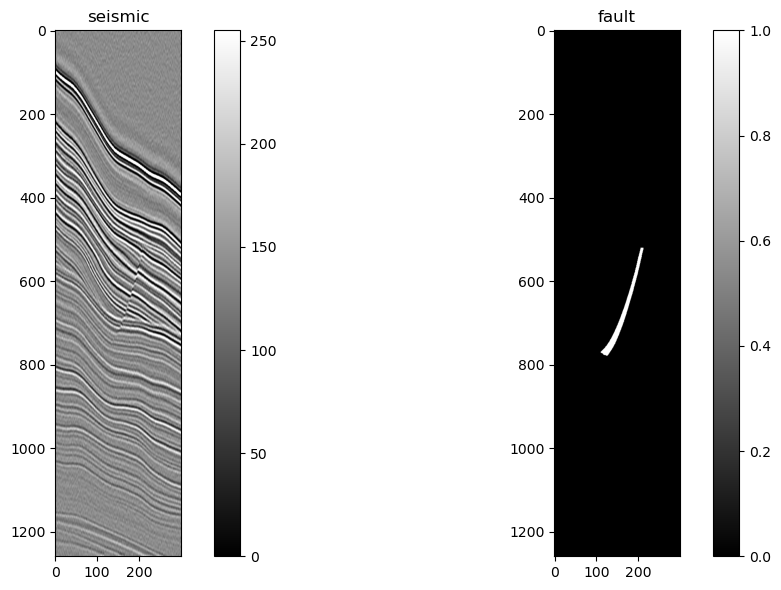

In [5]:
seismic_rescaled = rescale_volume(seismic, low=2, high=98)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax[0].imshow(seismic_rescaled[220, ...].T, cmap="gray")
ax[0].set_title("seismic")
fig.colorbar(im1, ax=ax[0], orientation="vertical")

# Plot the second image with a colorbar
im2 = ax[1].imshow(fault[220, ...].T, cmap="gray")
ax[1].set_title("fault")
fig.colorbar(im2, ax=ax[1], orientation="vertical")

plt.tight_layout()
plt.show()

### Your Solution
Your task is summarized below.

**Objective**: Develop a model that processes a 3D seismic volume (input) and identifies fault locations.

**Input**: A 3D seismic volume.

**Output**: A 3D array of the same dimensions as the input seismic volume, containing binary values where:

* 1 indicates a fault location
* 0 indicates no fault

### Submission File Generation

Your submission should be an `.npz` file containing 50 arrays. Each array’s name should be the sample ID (from the test dataset), and the array’s values should be the coordinates of the faults (i.e., the coordinates of the `1`’s for a given sample in the test dataset).

**Important Note:** The sample ID is the **name of the folder** containing the seismic volume, **NOT** the name of the `.npy` file of the seismic volume! For example, sample IDs for the training dataset are saved (with five of them printed) in the variable `sample_ids` earlier in this notebook.

To assist you in creating the `.npz` submission file, we have provided a function called `create_submission()` in the `utils.py` module. This function takes the sample ID (as a string) and the corresponding fault array, extracts the fault coordinates in the correct axes order, and adds them along with the sample ID to an `.npz` submission file with a name of your choice for the submission file. You can use this function in a loop for the 50 samples in the test dataset to create and populate your final `.npz` submission file, containing all 50 sample IDs in the test dataset along with your predicted fault coordinates.

**Important Note:** If you choose not to use this function, please ensure you understand the format and structure of the required `.npz` file, as well as how and in what axes order the fault coordinates must be extracted and saved.


To clarify the points mentioned above, let’s walk through a simple example of predicting faults and saving them in an `.npz` file using the `create_submission()` function.

For simplicity, we’ll consider the first five samples in the training dataset, whose IDs were saved in `sample_ids` earlier in the notebook. In the for loop below, we generate a dummy fault prediction for each of these five samples using the `dummy_prediction()` function from the `utils.py` module. Within the same loop, we call the `create_submission()` function, passing the sample ID, the dummy fault prediction array, and a name for the submission file. This process generates a sample `.npz` file containing the five samples from the `sample_ids` list and their fault coordinates in the required format. Once you have a trained model for fault prediction, you can repeat this process with the sample IDs of the test dataset and your fault prediction model (instead of the `dummy_prediction()` model) to generate and save your `.npz` submission file.

In [6]:
for sample_id in sample_ids[:5]:

    print("Sample ID:", sample_id)

    # Load 3D seismic volume
    sample_path = os.path.join(training_data, sample_id)
    input_volume_path = glob(f"{sample_path}/seismicCubes*.npy")
    input_volume = np.load(*input_volume_path)

    # Generates a dummy prediction for fault locations in a 3D seismic volume.
    # This line should be changed to your actual trained model for fault prediction
    prediction = dummy_prediction(input_volume)
    print("Prediction shape:", prediction.shape)
    print("Total number of predicted fault locations:", np.sum(prediction))

    # this line creates the submission .npz file and populates it with sample IDs and their fault coordinates
    create_submission(
        sample_id, prediction, "dark-side-sample-submission.npz", append=True
    )

Sample ID: 2023-10-05_0552b11a
Prediction shape: (300, 300, 1259)
Total number of predicted fault locations: 3398323
File not found, new submission will be created.
Sample ID: 2023-10-05_03b796af
Prediction shape: (300, 300, 1259)
Total number of predicted fault locations: 3400599
Sample ID: 2023-10-05_051be4a8
Prediction shape: (300, 300, 1259)
Total number of predicted fault locations: 3401634
Sample ID: 2023-10-05_03f23215
Prediction shape: (300, 300, 1259)
Total number of predicted fault locations: 3397901
Sample ID: 2023-10-05_0283ecc5
Prediction shape: (300, 300, 1259)
Total number of predicted fault locations: 3396997


### Evaluation

To evaluate your predictions, we will use the Dice metric. The Dice coefficient, or Dice score, is a statistical measure that quantifies the similarity between two sets of data. It is defined as twice the size of the intersection divided by the sum of the sizes of the two sets.

In this challenge, the sets refer to the fault arrays. For each sample, the Dice score is calculated between the predicted and ground-truth fault volumes. This calculation is performed for the 50 samples in the test dataset and then averaged to determine your final Dice score. For detailed information on how your submission will be evaluated and your final score calculated, refer to the `get_dice()` and `get_submission_score()` functions in the `utils.py` module.

To further assist your understanding of the evaluation process, let’s walk through a simple example using the same five samples in the training set stored in `sample_ids`. Since these samples are from the training set, you have access to their fault data and can generate the ground-truth `.npz` file for them. Let’s start with that below.

In [7]:
for sample_id in sample_ids[:5]:

    print("Sample ID:", sample_id)

    # loading ground-truth fault arrays
    sample_path = os.path.join(training_data, sample_id)
    fault_path = glob(f"{sample_path}/fault_*.npy")
    ground_truth = np.load(*fault_path)

    # creating a .npz file and populating it with sample IDs and their ground-truth fault coordinates
    create_submission(
        sample_id, ground_truth, "dark-side-sample-submission_gt.npz", append=True
    )

Sample ID: 2023-10-05_0552b11a
File not found, new submission will be created.
Sample ID: 2023-10-05_03b796af
Sample ID: 2023-10-05_051be4a8
Sample ID: 2023-10-05_03f23215
Sample ID: 2023-10-05_0283ecc5


Now that we have the ground-truth fault coordinates for the five samples in `sample_ids`, we can use the `get_submission_score()` function to calculate the final Dice score for the dummy prediction we saved earlier. Naturally, if a prediction is perfect, the `.npz` submission will match the ground-truth `.npz` file exactly, resulting in a perfect score. Below, we calculate the final Dice score for both the dummy and perfect predictions for the five training samples in `sample_ids`.

In [8]:
start_time = time.time()
dummy_score = get_submission_score(
    "dark-side-sample-submission_gt.npz", "dark-side-sample-submission.npz"
)
end_time = time.time()
execution_time = end_time - start_time
print("Dummy score:", dummy_score)
print("Execution_time", int(execution_time), "s")

start_time = time.time()
gt_score = get_submission_score(
    "dark-side-sample-submission_gt.npz", "dark-side-sample-submission_gt.npz"
)
end_time = time.time()
execution_time = end_time - start_time
print("\nPrefect score:", gt_score)
print("Execution_time", int(execution_time), "s")

Dummy score: 0.00932073064123967
Execution_time 1 s

Prefect score: 1.0
Execution_time 1 s


## Thank you for choosing to participate in this challenge! 
## Best of luck with your fault predictions!

# Extras!

As outlined in the challenge overview on our website, one traditional method for fault detection is spectral decomposition. Imagine spectral decomposition like a prism: when you shine white light through it, the light splits into its various wavelengths. Similarly, for seismic data, spectral decomposition is performed in the frequency domain, measuring the seismic amplitude for specific frequency bands. The results are typically visualized by assigning different colors to various frequencies.

To assist you, we’ve included some functions in the `utils.py` module for performing spectral decomposition on the provided 3D seismic volumes. Think of spectral decomposition analysis as a feature engineering tool that can be integrated with your deep learning models. Feel free to experiment with, modify, and utilize this tool and the provided functions as you see fit. While we believe spectral decomposition analysis is a powerful tool for fault prediction, it is not mandatory for this challenge.

Below, we briefly demonstrate how to use the provided utility functions for this analysis.


Given that spectral decomposition for large arrays can be computationally intensive, we’ll demonstrate the process using a smaller section of a seismic volume. First, we’ll load one of the seismic samples from the `sample_ids`. Then, we’ll extract a portion of this sample and save it as a new, reduced seismic volume.

In [9]:
training_data = os.path.join(os.getcwd(), "training_data")
sample_id = sample_ids[0]
sample_path = os.path.join(training_data, sample_id)
file_path = glob(f"{sample_path}/seismicCubes*.npy")[0]

seismic_full = np.load(file_path, allow_pickle=True)
seismic_section = seismic_full[:, :, 1100:1200]
np.save("seismic_section.npy", seismic_section)

Now let’s walk through the 5-step workflow for spectral decomposition analysis on the reduced seismic volume.

- Step 1: Load in `.npy` seismic amplitude 3D volume using the `load_seismic_data()` function.

In [10]:
seismic = load_seismic_data(filepath="./seismic_section.npy")

- Step 2: Plot seismic data to make sure it looks like seismic amplitudes. 

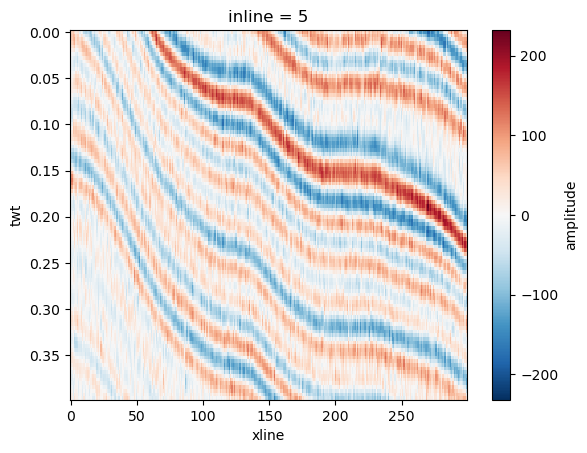

In [11]:
inline = 5
seismic.isel({"inline": inline}).T.plot.imshow(ax=plt.gca(), origin="upper")
plt.show()

- Step 3: If no metadata exists about the sampling frequency, extract mean from the data. 

In [12]:
fs, window = get_sampling_freq_window_length(seismic)

Mean sampling frequency is: 250.0
Window length is: 0.198


- Step 4: Run spectral decomposition on 3D seismic amplitude volume using the `spec_decomp()` function.

In [13]:
spec_decomp = spectral_decomp(seismic, fs=fs, window=0.2, fft_mode="onesided")

- Step 5: Plot and inspect the results.

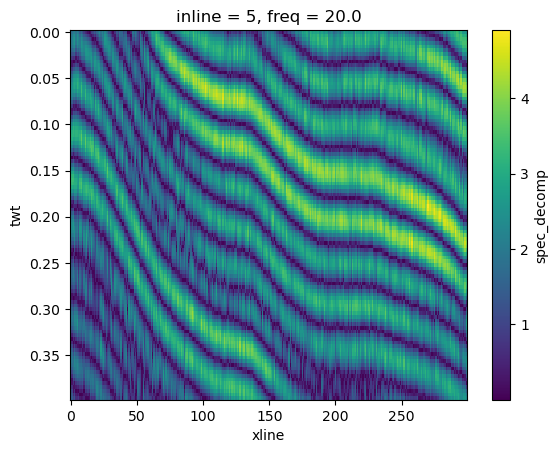

In [14]:
# Plot single inline from spec_decomp only
spec_decomp.isel({"inline": inline, "freq": 4}).T.plot.imshow(
    cmap="viridis", add_colorbar=True, origin="upper"
)
plt.show()

You can loop through all frequencies in spec decomp volume and overlay on top of seismic amplitudes. Below we show this for three frequencies.

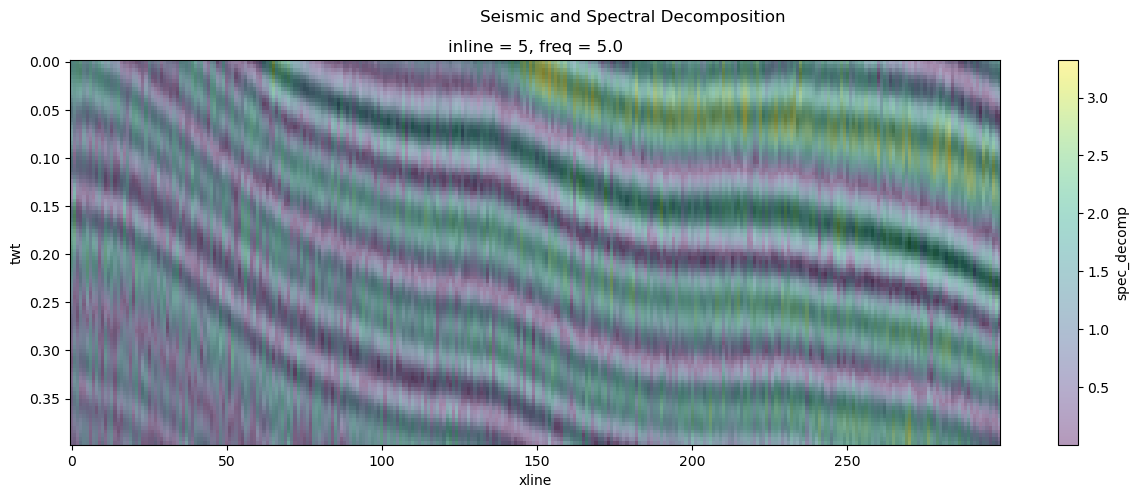

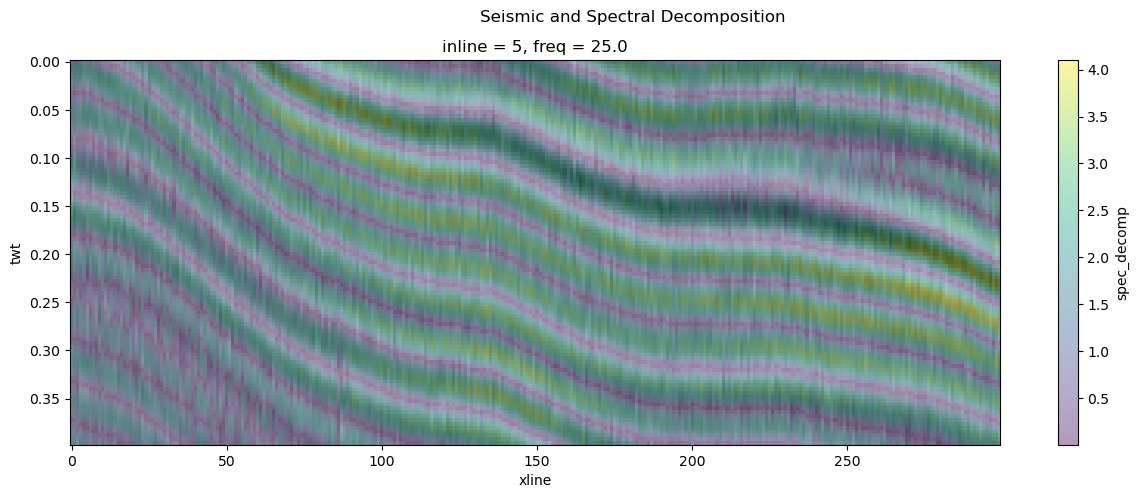

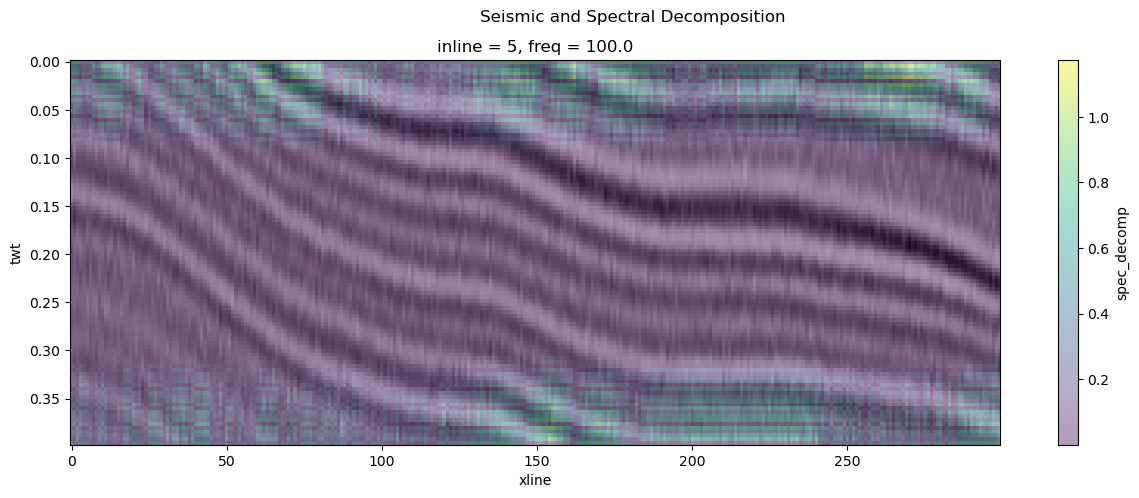

In [15]:
for idx in [
    1,
    5,
    20,
]:  # you can use idx in range(1, len(spec_decomp['freq'])) for all the freqs.
    plot_inline_spec_decomp_amplitude(spec_decomp, seismic, inline=inline, freq_idx=idx)